# Projeto de Detecção de Fraudes com Aprendizado Supervisionado

Este trabalho tem como objetivo aplicar técnicas de aprendizado de máquina para detecção de transações fraudulentas. O dataset utilizado contém registros financeiros simulados, com rótulo de fraude, e será preparado para treinar e avaliar diferentes modelos supervisionados. O conjunto de dados está disponível em: https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction


# Preparando ambiente

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pré-processamento

### 01 - Integração dos dados

NameError: name 'pd' is not defined

Conhecendo os dados

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Significado das colunas do dataset:**

step - tempo da transação em horas (relativo ao início do registro)

type - Tipo de transação, exemplo: CASH-IN, CASH-OUT, DÉBITO, PAGAMENTO e TRANSFERÊNCIA.

amount - valor da transação.

nameOrig - Id do cliente de origem

oldbalanceOrg - saldo do cliente de origem antes da transação

newbalanceOrig - saldo do cliente de origem após a transação

nameDest - ID do cliente de destino.

oldbalanceDest - saldo do cliente de destino antes da transação.

newbalanceDest - saldo do cliente de destino após a transação.

isFraud - rótulo da variável-alvo (0 = legítima, 1 = fraude).

isFlaggedFraud - indica se o sistema interno suspeitou da fraude (1 = sim).

In [ ]:
# Diferença de saldo antes e depois da transação
data['diffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['diffDest'] = data['newbalanceDest'] - data['oldbalanceDest']

# Flags se o saldo de origem ou destino era zero
data['origZero'] = (data['oldbalanceOrg'] == 0).astype(int)
data['destZero'] = (data['oldbalanceDest'] == 0).astype(int)

In [ ]:
data.shape

(6362620, 15)

In [ ]:
# Descrição dos tipos de cada coluna
data.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


Escolhemos esse dataset por ser relevante (fraude bancária é um problema real), desafiador (desequilíbrio entre classes) e com múltiplos atributos numéricos e categóricos que exigem processamento adequado.

### 02 - Limpeza

In [ ]:
# Verificando a presença de valores nulos
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
# Verificando a presença de valores duplicados
data.duplicated().sum()

np.int64(0)

In [ ]:
# Buscando erros, exemplo: verificando transações de valores negativos
data[data['amount'] < 0]
data[data['oldbalanceOrg'] < 0]
data[data['newbalanceDest'] < 0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffOrig,diffDest,origZero,destZero


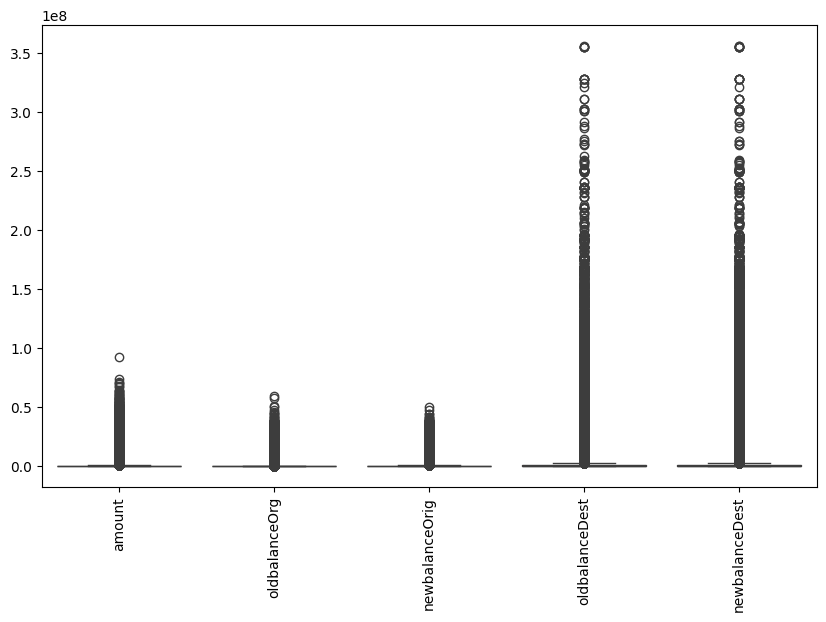

In [ ]:
# Buscando ruídos
colunas_desejadas = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data[colunas_desejadas])
plt.xticks(rotation=90)
plt.show()

No nosso caso não iremos descartar ruídos, pois para a identificação de fraudes como essas, esses valores são cruciais que nosso modelo deve levar em consideração para análise

Aplicamos a redução antes porque iremos criar novas instancias e normaliza-las, caso não fizessemos isso, os resultados seriam diferentes

### 03 - Transformação

#### Normalização

A normalização via Z-score foi escolhida para manter a distribuição dos dados. Isso é essencial para algoritmos como KNN e redes neurais, que são sensíveis à escala dos atributos. O uso do `StandardScaler` garante que cada variável tenha média 0 e desvio padrão 1.

In [ ]:
# Aplicando o Z-score nas colunas com transações
from sklearn.preprocessing import StandardScaler

colunas_normalizar = ['amount', 'step', 'oldbalanceOrg', 'newbalanceOrig',
                      'oldbalanceDest', 'newbalanceDest', 'diffOrig', 'diffDest']

scaler = StandardScaler()
data[colunas_normalizar] = scaler.fit_transform(data[colunas_normalizar])

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffOrig,diffDest,origZero,destZero
0,-1.703042,PAYMENT,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,0.211876,-0.152896,0,1
1,-1.703042,PAYMENT,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,0.157490,-0.152896,0,1
2,-1.703042,TRANSFER,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,0.146011,-0.152896,0,1
3,-1.703042,CASH_OUT,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,0.146011,-0.178952,0,0
4,-1.703042,PAYMENT,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,0.224345,-0.152896,0,1


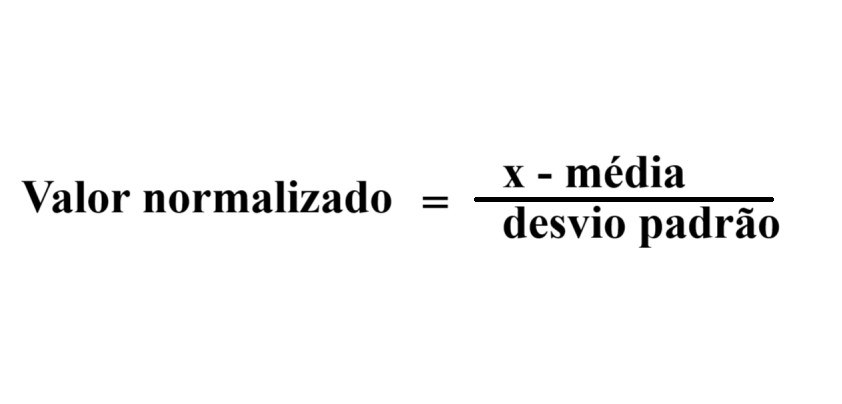

Normalização é importante para algoritmos sensíveis as escalas como KNN e redes neurais

#### Discretização

A discretização foi aplicada para transformar dados contínuos em categorias facilitando a análise, a visualização e se adaptando a entrada de determinados modelos.

Vantagens bin por frequência: Cria compartimentos balanceados e lidam melhor com outliers
Desvantagens bin por frequência: Pode distorcer distribuição dos dados

Usamos a discretização (binning por frequência) na variável `amount` para facilitar visualizações e análises. Isso é útil para destacar padrões de comportamento em transações fraudulentas.


In [ ]:
# Exemplo com 10 intervalos
data['amount_faixa'] = pd.qcut(data['amount'], q=10)

<ipython-input-14-c56d84b78dfa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quartis_labels, y=quartis_contagem.values, palette='Blues')


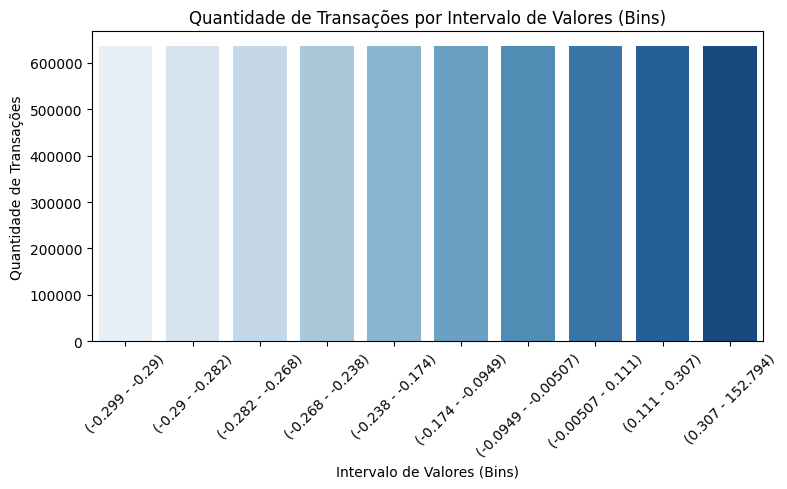

In [ ]:
quartis_contagem = data['amount_faixa'].value_counts().sort_index()
quartis_labels = [f'({str(interval.left)} - {str(interval.right)})' for interval in data['amount_faixa'].cat.categories]

plt.figure(figsize=(8, 5))
sns.barplot(x=quartis_labels, y=quartis_contagem.values, palette='Blues')
plt.title('Quantidade de Transações por Intervalo de Valores (Bins)')
plt.xlabel('Intervalo de Valores (Bins)')
plt.ylabel('Quantidade de Transações')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 04 - Redução

Redução de atributos

In [ ]:
data_model = data.copy()

# Colunas descartadas, pois podem causar overfitting
data_model = data_model.drop(columns=['nameOrig', 'nameDest'])

In [ ]:
data_model

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffOrig,diffDest,origZero,destZero,amount_faixa
0,-1.703042,PAYMENT,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,0.211876,-0.152896,0,1,"(-0.29, -0.282]"
1,-1.703042,PAYMENT,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,0.157490,-0.152896,0,1,"(-0.299, -0.29]"
2,-1.703042,TRANSFER,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,1,0,0.146011,-0.152896,0,1,"(-0.299, -0.29]"
3,-1.703042,CASH_OUT,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,1,0,0.146011,-0.178952,0,0,"(-0.299, -0.29]"
4,-1.703042,PAYMENT,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,0.224345,-0.152896,0,1,"(-0.282, -0.268]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,3.510123,CASH_OUT,0.264665,-0.171108,-0.292442,-0.323814,-0.240959,1,0,2.461161,0.264949,0,1,"(0.111, 0.307]"
6362616,3.510123,TRANSFER,10.153953,1.896491,-0.292442,-0.323814,-0.333411,1,0,43.183977,-0.152896,0,1,"(0.307, 152.794]"
6362617,3.510123,CASH_OUT,10.153953,1.896491,-0.292442,-0.303665,1.403027,1,0,43.183977,7.610798,0,0,"(0.307, 152.794]"
6362618,3.510123,TRANSFER,1.109765,0.005581,-0.292442,-0.323814,-0.333411,1,0,5.941173,-0.152896,0,1,"(0.307, 152.794]"


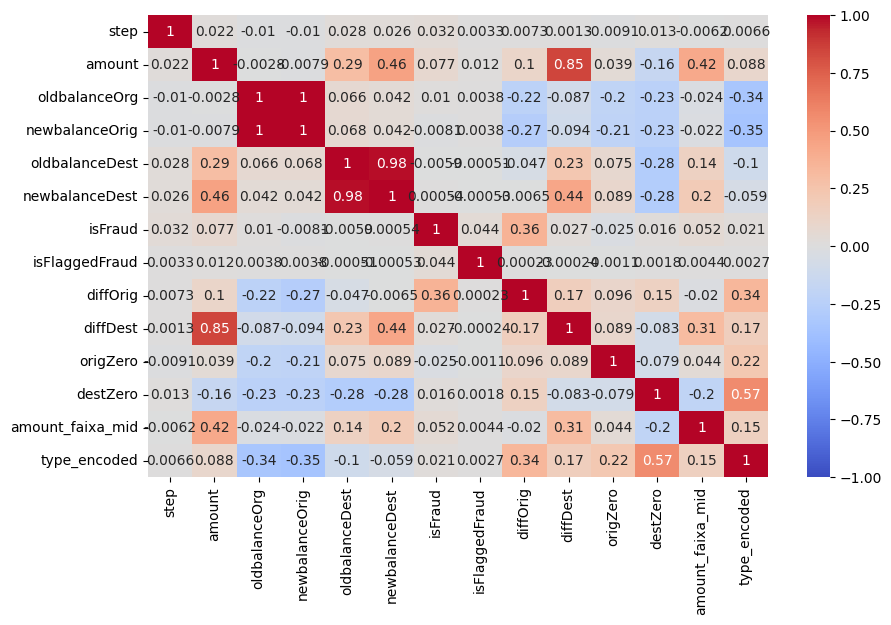

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convertendo amount_faixa de intervalo para o ponto médio (numérico)
data_model['amount_faixa_mid'] = data_model['amount_faixa'].apply(lambda x: (x.left + x.right) / 2)

# Convertendo a variável 'type' (string) para numérico
label_encoder = LabelEncoder()
data_model['type_encoded'] = label_encoder.fit_transform(data_model['type'])
data_model['type_encoded'] = scaler.fit_transform(data_model[['type_encoded']])

data_model = data_model.drop(columns=['type', 'amount_faixa'])

# Calculando a correlação
correlation_matrix = data_model.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Remoção baseada na matriz de correlação. Atributos com correlação muito alta entre si são redundantes e podem causar overfitting.

In [ ]:
# Removendo atributos
data_model = data_model.drop(columns=['amount_faixa_mid', # redundante e pouco informativa em relação a amount
                                      'newbalanceOrig', # Correlação = 1 com oldbalanceOrig (redundante)
                                      'oldbalanceDest', # Correlação = 0.98 com newbalanceDest (redundante)
                                      'diffDest' # Alta correlação com amount 0.85 (redundante)
])

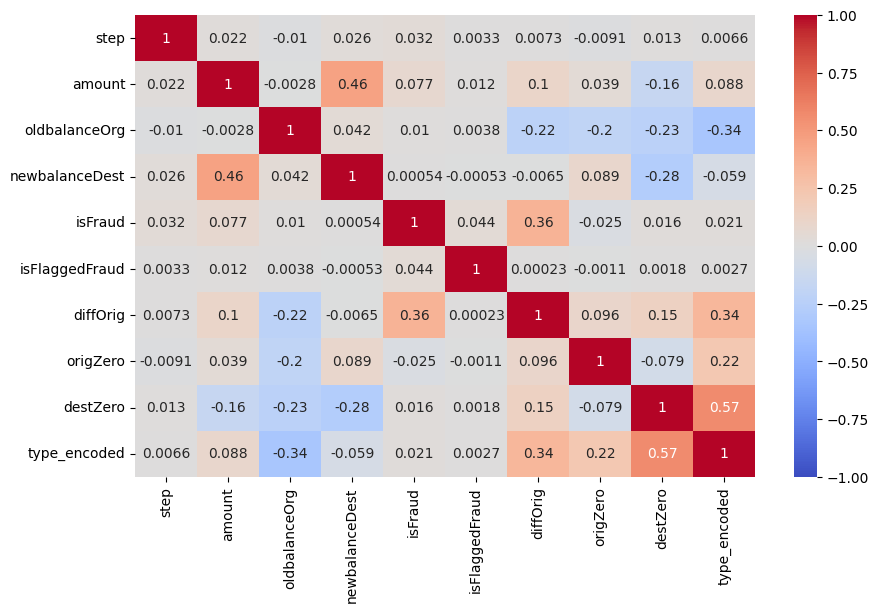

In [ ]:
# Matriz de correlação final
correlation_matrix = data_model.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Redução de instâncias

A base original é desbalanceada (fraudes são minoria). Por isso, usamos amostragem estratificada para manter a proporção da classe alvo (isFraud) nos dados de treino e teste, evitando que o modelo seja "tendencioso" em favor da classe majoritária

In [ ]:
# Amostragem estratificada
data_reduzido = data_model.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=42))

<ipython-input-20-86518d26b13b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_reduzido = data_model.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=42))


In [ ]:
data_reduzido.shape

(1272524, 10)

# Modelo supervisionado e avaliação

Selecionamos três algoritmos supervisionados com características complementares:

- **KNN:** Simples e eficaz, mas sensível à escala e à dimensionalidade.
- **Árvore de Decisão:** Interpretação fácil, lida bem com atributos categóricos.
- **MLP (Rede Neural):** Modelo mais robusto, porém mais sujeito a overfitting sem ajuste.

Todos serão comparados com as mesmas métricas para avaliar desempenho.


In [ ]:
from sklearn.model_selection import train_test_split

X = data_reduzido.drop('isFraud', axis=1)
y = data_reduzido['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Avaliação dos modelos


==== Métricas médias dos Modelos (Cross-Validation em X_train - 10 folds) ====

                   Acurácia  Precisão  Revocação     F1
KNN                   0.999     0.843      0.570  0.679
Rede Neural           1.000     0.944      0.660  0.775
Árvore de Decisão     0.999     0.773      0.783  0.777


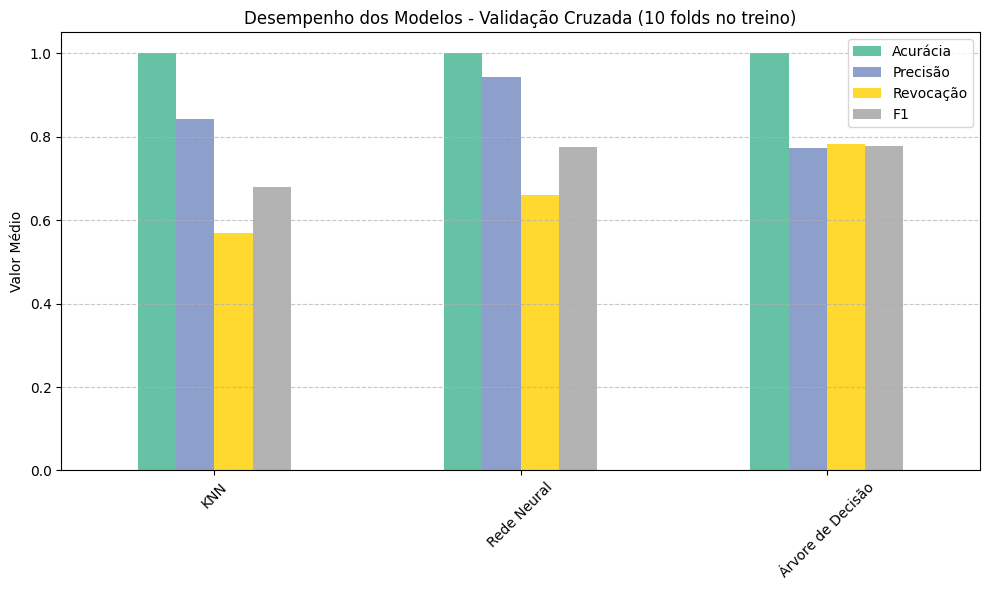

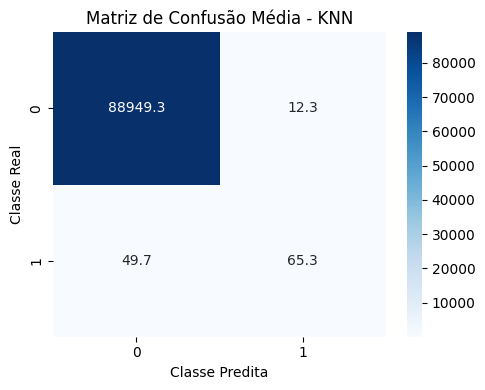

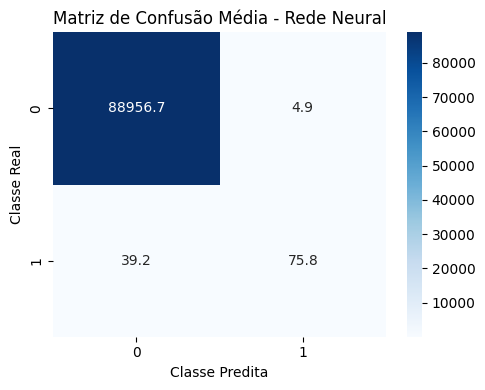

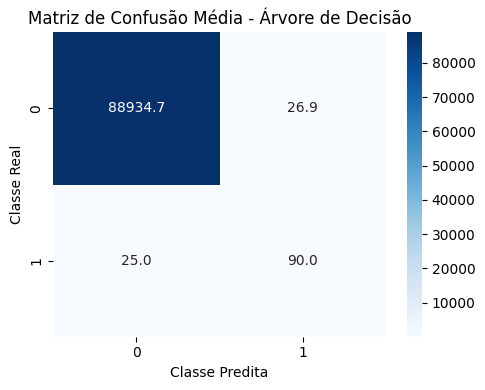

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos
modelos = {
    "KNN": KNeighborsClassifier(),
    "Rede Neural": MLPClassifier(max_iter=1000, random_state=42),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42)
}

metricas = ["Acurácia", "Precisão", "Revocação", "F1"]
resultados = {nome: {m: [] for m in metricas} for nome in modelos}
matrizes = {}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for nome, modelo in modelos.items():
    matriz_total = np.zeros((2, 2))

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]


        modelo.fit(X_tr, y_tr)
        y_pred = modelo.predict(X_val)

        resultados[nome]["Acurácia"].append(accuracy_score(y_val, y_pred))
        resultados[nome]["Precisão"].append(precision_score(y_val, y_pred, zero_division=0))
        resultados[nome]["Revocação"].append(recall_score(y_val, y_pred, zero_division=0))
        resultados[nome]["F1"].append(f1_score(y_val, y_pred, zero_division=0))

        matriz_total += confusion_matrix(y_val, y_pred, labels=[0, 1])

    matrizes[nome] = matriz_total / 10

# DataFrame com as métricas médias
df_metricas = pd.DataFrame({
    nome: {m: np.mean(resultados[nome][m]) for m in metricas}
    for nome in modelos
}).T

print("\n==== Métricas médias dos Modelos (Cross-Validation em X_train - 10 folds) ====\n")
print(df_metricas.round(3))

# Gráfico de barras
df_metricas.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("Desempenho dos Modelos - Validação Cruzada (10 folds no treino)")
plt.ylabel("Valor Médio")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Matrizes de confusão médias
for nome, matriz in matrizes.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz, annot=True, fmt=".1f", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matriz de Confusão Média - {nome}")
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.tight_layout()
    plt.show()

Ajuste de hiperparâmetros:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print(f"Melhor valor de k: {grid.best_params_}")

Melhor valor de k: {'n_neighbors': 3}
